# PPO algorithm

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec, tensor_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import policy_step as ps
from tf_agents.typing import types
from tf_agents.policies import random_py_policy
from tf_agents.policies import epsilon_greedy_policy
from tf_agents.policies import random_tf_policy
from tf_agents.policies import py_policy
from tf_agents.metrics import py_metrics
from tf_agents.metrics import tf_metrics
from tf_agents.drivers import py_driver
from tf_agents.drivers import tf_driver
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import dynamic_step_driver
from tf_agents.policies import py_tf_eager_policy
from tf_agents.networks import actor_distribution_network
from tf_agents.networks import value_network
from tf_agents.agents import PPOAgent
from tf_agents.utils import common as cmn

import matplotlib.pyplot as plt
import qutip
from qutip import sigmap, expect

import random

import sys
sys.path.append('../')
from common.common import get_average_return, extract_single_action_policy

%matplotlib inline

2024-03-11 23:08:32.240607: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-11 23:08:32.267893: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-11 23:08:32.267913: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-11 23:08:32.269047: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-11 23:08:32.275784: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-11 23:08:32.276166: I tensorflow/core/platform/cpu_feature_guard.cc:1

* System parameters

In [2]:
T = 5 # terminal time step
max_steps = 35 # number of time steps
random.seed(1989)

* Create training and evaluation environments and define actions

In [3]:
# validate environment
from environments.qubit_env import QubitResonantContEnv

# define actions
# TODO: actions can be continuous within a range of course 
# actions will be the change in the magnetic field
max_Ω = 1.0

environment = QubitResonantContEnv(T, max_steps, max_Ω, fidelity_threshold = 0.9999, verbose_fg = False)
eval_environment = QubitResonantContEnv(T, max_steps, max_Ω, fidelity_threshold = 0.9999, verbose_fg = False)

train_env = tf_py_environment.TFPyEnvironment(environment)
eval_env = tf_py_environment.TFPyEnvironment(eval_environment)

In [4]:
fc_layer_params = (100, 75)
learning_rate = 1e-3
replay_buffer_capacity = 100000
num_iterations = 1500
nb_episodes = 1
eval_interval = 10
checkpoint_dir = "/home/dkoytrom/Msc_Quantum_Computing_Quantum_Technologies/Master_Thesis/algorithms/classical/Reinforcement_learning/checkpoints/ppo_qubit_resonant_cont_e-4_error/"

In [5]:
actor_network = actor_distribution_network.ActorDistributionNetwork(
    input_tensor_spec = train_env.observation_spec(),
    output_tensor_spec = train_env.action_spec(),
    fc_layer_params = fc_layer_params,
    name = "Policy",
)

# use tha Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

train_step_counter = tf.Variable(0)

value_net = value_network.ValueNetwork(
    input_tensor_spec = train_env.observation_spec(),
    fc_layer_params = (100, 50, ),
    name = 'ValueNet'
) 

agent = PPOAgent(
    time_step_spec = train_env.time_step_spec(),
    action_spec = train_env.action_spec(),
    actor_net = actor_network,
    value_net = value_net,
    optimizer = optimizer,
    train_step_counter = train_step_counter,
)

agent.initialize()

2024-03-11 23:08:34.349456: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: dkoytrom-pc
2024-03-11 23:08:34.349471: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: dkoytrom-pc
2024-03-11 23:08:34.349547: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2024-03-11 23:08:34.349570: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 550.54.14


In [6]:
# collect trajectories
import reverb
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils

table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size = replay_buffer_capacity,
    sampler = reverb.selectors.Uniform(),
    remover = reverb.selectors.Fifo(),
    rate_limiter = reverb.rate_limiters.MinSize(1),
    signature = replay_buffer_signature
)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name = table_name,
    sequence_length = None,
    local_server = reverb_server
)

rb_observer = reverb_utils.ReverbAddEpisodeObserver(
    replay_buffer.py_client,
    table_name,
    replay_buffer_capacity
)

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = cmn.function(agent.train)

# create a driver which will run the simulations and collect tha dataset for our training
collect_driver = py_driver.PyDriver(
    environment,
    py_tf_eager_policy.PyTFEagerPolicy(agent.collect_policy, use_tf_function = True),
    observers = [rb_observer],
    max_episodes = nb_episodes
)

""" checkpointer = cmn.Checkpointer(
    ckpt_dir = checkpoint_dir,
    max_to_keep = 1,
    agent = agent,
    policy = agent.policy,
    replay_buffer = replay_buffer,
)

checkpointer.initialize_or_restore() """

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpi9tu473t.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmpi9tu473t
[reverb/cc/platform/default/server.cc:71] Started replay server on port 38959


' checkpointer = cmn.Checkpointer(\n    ckpt_dir = checkpoint_dir,\n    max_to_keep = 1,\n    agent = agent,\n    policy = agent.policy,\n    replay_buffer = replay_buffer,\n)\n\ncheckpointer.initialize_or_restore() '

In [7]:
avg_returns = [get_average_return(eval_env, agent.policy, 10)]

for _ in range(num_iterations):
    initial_time_step = environment.reset()
    collect_driver.run(initial_time_step)

    # create dataset from trajectories
    dataset = replay_buffer.as_dataset(sample_batch_size = 1)
    iterator = iter(dataset)

    trajectories , _ = next(iterator)

    # train 
    train_loss = agent.train(experience = trajectories)

    replay_buffer.clear()

    step = agent.train_step_counter.numpy()

    if step % 50 == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss.loss))

    if step % eval_interval == 0:
        avg_return = get_average_return(eval_env, agent.policy, 10)
        avg_returns.append(avg_return)


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (709857) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (709857) so Table uniform_table is accessed directly without gRPC.


step = 50: loss = 267.0441589355469


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (709857) so Table uniform_table is accessed directly without gRPC.


step = 100: loss = 38.18602752685547
step = 150: loss = 33.591861724853516


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (709857) so Table uniform_table is accessed directly without gRPC.


step = 200: loss = 0.47778040170669556
step = 250: loss = 0.4331236183643341
step = 300: loss = 0.19704371690750122
step = 350: loss = 0.40284156799316406


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (709857) so Table uniform_table is accessed directly without gRPC.


step = 400: loss = 0.11300194263458252
step = 450: loss = 28.214914321899414
step = 500: loss = 27.58843421936035
step = 550: loss = 5.669550895690918
step = 600: loss = 1.7421557903289795
step = 650: loss = 0.411075234413147
step = 700: loss = 0.4096313714981079
step = 750: loss = 31.500513076782227


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (709857) so Table uniform_table is accessed directly without gRPC.


step = 800: loss = 1.3285101652145386
step = 850: loss = 0.7719943523406982
step = 900: loss = 6.392871856689453
step = 950: loss = 10.893411636352539
step = 1000: loss = 1.792636752128601
step = 1050: loss = 4.369149684906006
step = 1100: loss = 0.3994804918766022
step = 1150: loss = 29.31557846069336
step = 1200: loss = 1.2196645736694336
step = 1250: loss = 3.26369571685791
step = 1300: loss = 15.846007347106934
step = 1350: loss = 1.0258198976516724
step = 1400: loss = 0.18618859350681305
step = 1450: loss = 22.179340362548828
step = 1500: loss = 2.1808125972747803
step = 1550: loss = 6.649351596832275


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (709857) so Table uniform_table is accessed directly without gRPC.


step = 1600: loss = 8.862648963928223
step = 1650: loss = 10.51063060760498
step = 1700: loss = 2.4698233604431152
step = 1750: loss = 4.53448486328125
step = 1800: loss = 1.2075358629226685
step = 1850: loss = 8.360542297363281
step = 1900: loss = 4.616888999938965
step = 1950: loss = 1.154098391532898
step = 2000: loss = 0.3772803544998169
step = 2050: loss = 21.030691146850586
step = 2100: loss = 2.552050828933716
step = 2150: loss = 10.361994743347168
step = 2200: loss = 4.715439796447754
step = 2250: loss = 1.4473695755004883
step = 2300: loss = 5.470785140991211
step = 2350: loss = 1.9664971828460693
step = 2400: loss = 1.4283231496810913
step = 2450: loss = 20.160350799560547
step = 2500: loss = 3.529458522796631
step = 2550: loss = 0.7290329933166504
step = 2600: loss = 0.1202930212020874
step = 2650: loss = 0.16992515325546265
step = 2700: loss = 0.07282857596874237
step = 2750: loss = 12.842230796813965
step = 2800: loss = 9.602330207824707
step = 2850: loss = 9.7007150650024

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (709857) so Table uniform_table is accessed directly without gRPC.


step = 3200: loss = 0.992483913898468
step = 3250: loss = 17.741554260253906
step = 3300: loss = 4.699522018432617
step = 3350: loss = 3.526174545288086
step = 3400: loss = 3.8297042846679688
step = 3450: loss = 12.534149169921875
step = 3500: loss = 9.207587242126465
step = 3550: loss = 8.724004745483398
step = 3600: loss = 3.411513328552246
step = 3650: loss = 5.611415863037109
step = 3700: loss = 4.380417346954346
step = 3750: loss = 11.166744232177734
step = 3800: loss = 6.4562668800354
step = 3850: loss = 6.891303539276123
step = 3900: loss = 3.021352767944336
step = 3950: loss = 3.8692870140075684
step = 4000: loss = 5.396214962005615
step = 4050: loss = 5.4141364097595215
step = 4100: loss = 4.842334270477295
step = 4150: loss = 5.613708019256592
step = 4200: loss = 4.612641334533691
step = 4250: loss = 9.90316390991211
step = 4300: loss = 8.038036346435547
step = 4350: loss = 6.242320537567139
step = 4400: loss = 0.5288654565811157
step = 4450: loss = 0.07900141179561615
step =

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (709857) so Table uniform_table is accessed directly without gRPC.


step = 6400: loss = 3.707028388977051
step = 6450: loss = 3.802157402038574
step = 6500: loss = 5.8473381996154785
step = 6550: loss = 4.170900821685791
step = 6600: loss = 3.930711030960083
step = 6650: loss = 5.3605546951293945
step = 6700: loss = 0.5434885025024414
step = 6750: loss = 6.159793853759766
step = 6800: loss = 3.7841808795928955
step = 6850: loss = 0.20107628405094147
step = 6900: loss = 0.02809872291982174
step = 6950: loss = -0.0571359246969223
step = 7000: loss = -0.15706376731395721
step = 7050: loss = -0.14516118168830872
step = 7100: loss = 1.8473838567733765
step = 7150: loss = 0.01677362620830536
step = 7200: loss = 1.3644720315933228
step = 7250: loss = 3.55082368850708
step = 7300: loss = 1.790023922920227
step = 7350: loss = 0.08880375325679779
step = 7400: loss = 6.772609710693359
step = 7450: loss = 0.3863564133644104
step = 7500: loss = 0.05093023180961609
step = 7550: loss = -0.026671167463064194
step = 7600: loss = 0.0017660986632108688
step = 7650: loss 

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (709857) so Table uniform_table is accessed directly without gRPC.


step = 12800: loss = -0.0039590573869645596
step = 12850: loss = -0.0062344674952328205
step = 12900: loss = -0.00035015741013921797
step = 12950: loss = 0.00024696701439097524
step = 13000: loss = 0.0008915162179619074
step = 13050: loss = 0.000686261395458132
step = 13100: loss = -0.007111582905054092
step = 13150: loss = -0.4391830563545227
step = 13200: loss = -0.0038805073127150536
step = 13250: loss = -0.03056267276406288
step = 13300: loss = -0.10141578316688538
step = 13350: loss = -0.005284626968204975
step = 13400: loss = -0.0017069460591301322
step = 13450: loss = -0.034709785133600235
step = 13500: loss = -0.03162872791290283
step = 13550: loss = -0.0023598107509315014
step = 13600: loss = -0.6610954999923706
step = 13650: loss = -0.3458065092563629
step = 13700: loss = -0.007924795150756836
step = 13750: loss = -0.001473547425121069
step = 13800: loss = -0.12601077556610107
step = 13850: loss = -0.0075303055346012115
step = 13900: loss = -0.00970812514424324
step = 13950: 

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (709857) so Table uniform_table is accessed directly without gRPC.


step = 25600: loss = 0.006846204865723848
step = 25650: loss = 0.021986790001392365
step = 25700: loss = 0.031152572482824326
step = 25750: loss = 0.03631136938929558
step = 25800: loss = 0.008329779841005802
step = 25850: loss = 0.009454828687012196
step = 25900: loss = 0.026884380728006363
step = 25950: loss = 0.03998943790793419
step = 26000: loss = 0.02593347430229187
step = 26050: loss = 0.0040273829363286495
step = 26100: loss = 0.0015308554284274578
step = 26150: loss = 0.0017076128860935569
step = 26200: loss = -0.00443510664626956
step = 26250: loss = -0.0053408825770020485
step = 26300: loss = 0.002409121720120311
step = 26350: loss = 0.0017448480939492583
step = 26400: loss = 0.0022249333560466766
step = 26450: loss = 0.0006817214889451861
step = 26500: loss = 0.002964617218822241
step = 26550: loss = 0.0014915803913027048
step = 26600: loss = -0.0019613993354141712
step = 26650: loss = 0.00207029958255589
step = 26700: loss = -0.02230643481016159
step = 26750: loss = -0.021

In [8]:
# checkpointer.save(train_step_counter)

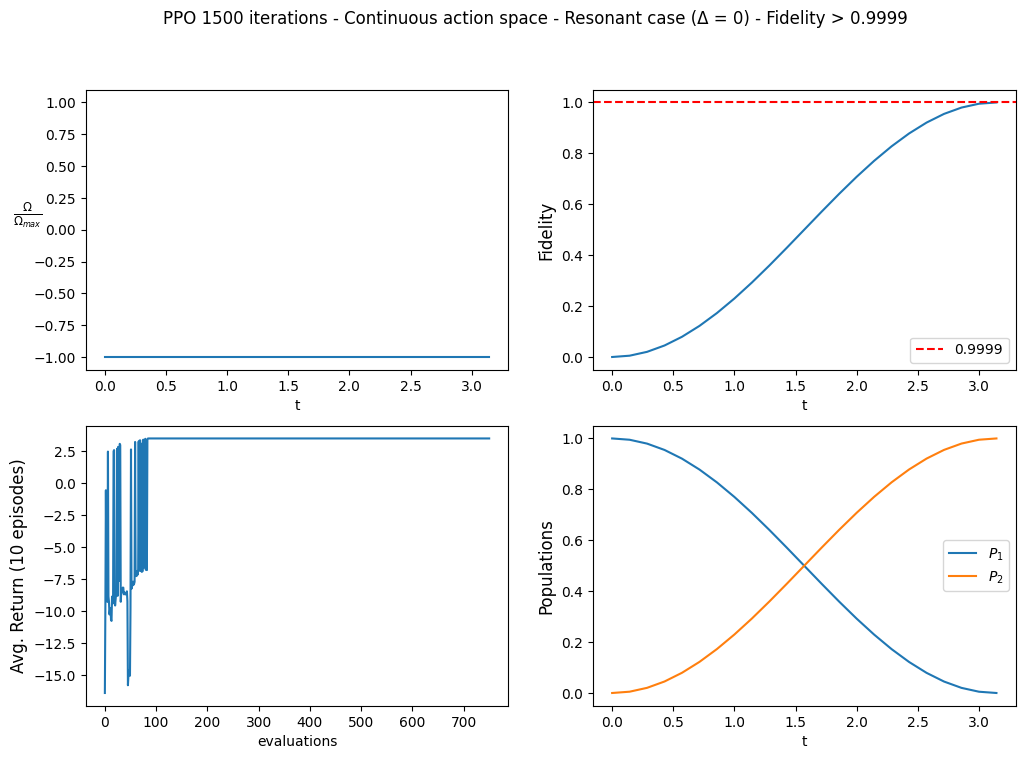

In [9]:
greedy_actions, optimal_omegas, states, fidelities = extract_single_action_policy(environment, agent)

population2 = expect(sigmap().dag() * sigmap(), states)
population1 = 1 - population2

time_span = np.arange(len(optimal_omegas))
time_span = [t * T / max_steps for t in time_span]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(8)
fig.set_figwidth(12)
fig.suptitle(f'PPO {num_iterations} iterations - Continuous action space - Resonant case (Δ = 0) - Fidelity > 0.9999')

ax1.step(time_span, optimal_omegas, where = 'post', label = 'Ω')
ax1.set_ylabel(r"$\frac{\Omega}{\Omega_{max}}$", rotation = 0, fontsize = 12)
ax1.set_ylim((-1.1, 1.1))
ax1.set_xlabel(f"t")

ax2.plot(time_span, fidelities)
ax2.axhline(y = 0.9999, color = 'r', linestyle = '--', label = '0.9999')
ax2.set_ylabel("Fidelity", rotation = 90, fontsize = 12)
ax2.set_xlabel(f"t")
ax2.legend(loc = 'lower right')

ax4.plot(time_span, population1, label = r"$P_1$")
ax4.plot(time_span, population2, label = r"$P_2$")
ax4.set_ylabel("Populations", rotation = 90, fontsize = 12)
ax4.set_xlabel(f"t")
ax4.legend()

time_span3 = range(len(avg_returns))
ax3.plot(time_span3, avg_returns)
ax3.set_ylabel("Avg. Return (10 episodes)", rotation = 90, fontsize = 12)
ax3.set_xlabel(f"evaluations")
plt.show()

In [10]:
time_span

[0.0,
 0.14285714285714285,
 0.2857142857142857,
 0.42857142857142855,
 0.5714285714285714,
 0.7142857142857143,
 0.8571428571428571,
 1.0,
 1.1428571428571428,
 1.2857142857142858,
 1.4285714285714286,
 1.5714285714285714,
 1.7142857142857142,
 1.8571428571428572,
 2.0,
 2.142857142857143,
 2.2857142857142856,
 2.4285714285714284,
 2.5714285714285716,
 2.7142857142857144,
 2.857142857142857,
 3.0,
 3.142857142857143]

In [11]:
fidelities

[0.0,
 0.005093367829702452,
 0.02026969803280032,
 0.045219789554230644,
 0.07943531601551847,
 0.12221918261727699,
 0.1726997286985559,
 0.22984848703184196,
 0.29250113866571964,
 0.35938123261709276,
 0.4291261946590296,
 0.5003150870546019,
 0.5714975570929475,
 0.641223383742842,
 0.708072021190598,
 0.7706815384859244,
 0.8277763655755929,
 0.8781932835527896,
 0.9209051223191026,
 0.9550416890712875,
 0.9799074978152489,
 0.9949959393553749,
 0.9999996030622255]